<a href="https://colab.research.google.com/github/GrzegorzHimself/Hunter-Prey-IQL/blob/main/HnP_IQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
Episode 5 out of 1000
Episode 6 out of 1000
Episode 7 out of 1000
Episode 8 out of 1000
Episode 9 out of 1000
Episode 10 out of 1000
Episode 11 out of 1000
Episode 12 out of 1000
Episode 13 out of 1000
Episode 14 out of 1000
Episode 15 out of 1000
Episode 16 out of 1000
Episode 17 out of 1000
Episode 18 out of 1000
Episode 19 out of 1000
Episode 20 out of 1000
Episode 21 out of 1000
Episode 22 out of 1000
Episode 23 out of 1000
Episode 24 out of 1000
Episode 25 out of 1000
Episode 26 out of 1000
Episode 27 out of 1000
Episode 28 out of 1000
Episode 29 out of 1000
Episode 30 out of 1000
Episode 31 out of 1000
Episode 32 out of 1000
Episode 33 out of 1000
Episode 34 out of 1000
Episode 35 out of 1000
Episode 36 out of 1000
Episode 37 out of 1000
Episode 38 out of 1000
Episode 39 out of 1000
Episode 40 out of 1000
Episode 41 out of 1000
Episode 42 out of 1000
Episode 43 out of 1000
Episode 44 out of 1000
Episode 45 out of 1000
Episode 46 

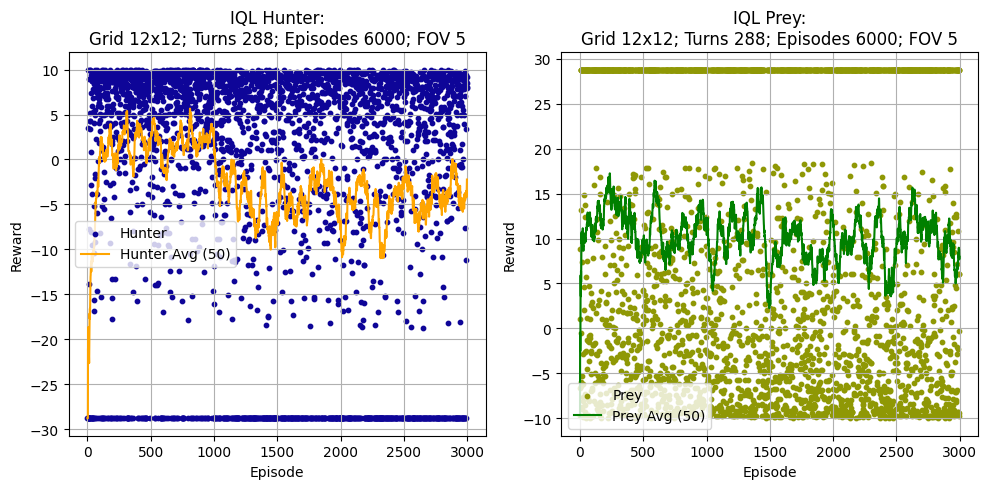

In [5]:
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anime
from matplotlib.animation import PillowWriter
import torch.nn.functional as F
import heapq



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# ------------------- REPLAY BUFFER ------------------- #
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Replay buffer setup for shuffle and mini-batch creation
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.long).to(device),
            torch.tensor(rewards, dtype=torch.float32).to(device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).to(device),
        )

    def __len__(self):
        return len(self.buffer)



# ------------------- DQN NETWORK ------------------- #
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))     # I love ReLU
        x = F.relu(self.fc2(x))
        return self.fc3(x)



# ------------------- AGENT ------------------- #
class Agent:
    def __init__(self, input_dim, n_actions, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1, lr=0.001):
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = DQN(input_dim, n_actions).to(device)
        self.target_model = DQN(input_dim, n_actions).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
# Nice
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(10000)

    def predict(self, state):
        if random.random() < self.epsilon:
            # Random action, exploration
            return random.randint(0, self.n_actions - 1)
        else:
            # Exploitation
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values = self.model(state_tensor)
                return torch.argmax(q_values).item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Current Q-values
        q_values = self.model(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Next Q-values
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]

        # Target Q-values
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Loss
        loss = self.criterion(q_values, target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



# ------------------- PLAYER ------------------- #
class Player:
    def __init__(self, x, y, fov_radius, grid_size):
        self.position = [x, y]
        self.fov_radius = fov_radius
        self.grid_size = grid_size
        self.vision = []

    def move(self, direction, walls):
        # Both Hunter and Prey can move only UP, DOWN, RIGHT, LEFT, and STAY (in place, basically skipping the step)
        x, y = self.position
        if direction == 0 and x > 0 and walls[x - 1][y] != "w":
            x -= 1      # UP
        elif direction == 1 and x < self.grid_size - 1 and walls[x + 1][y] != "w":
            x += 1      # DOWN
        elif direction == 2 and y > 0 and walls[x][y - 1] != "w":
            y -= 1      # LEFT
        elif direction == 3 and y < self.grid_size - 1 and walls[x][y + 1] != "w":
            y += 1      # RIGHT
        elif direction == 4:
            pass        # STAY
        self.position = [x, y]
        self.update_vision(walls)

    # Vision tool using Bresenham's line algorithm
    # Provides Hunter and Pray with a FOV (Field Of View) circle
    # In this circle, they "see" each other (see *move* function for details)
    # Walls block the circle, thus limiting the FOV
    def update_vision(self, walls):
        hx, hy = self.position
        self.vision = []

        def bresenham(x1, y1, x2, y2):
            points = []
            dx = abs(x2 - x1)
            dy = abs(y2 - y1)
            sx = 1 if x1 < x2 else -1
            sy = 1 if y1 < y2 else -1
            err = dx - dy

            while True:
                points.append((x1, y1))
                if x1 == x2 and y1 == y2:
                    break
                e2 = 2 * err
                if e2 > -dy:
                    err -= dy
                    x1 += sx
                if e2 < dx:
                    err += dx
                    y1 += sy

            return points

        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if np.sqrt((x - hx) ** 2 + (y - hy) ** 2) <= self.fov_radius:
                    line = bresenham(hx, hy, x, y)
                    visible = True
                    for lx, ly in line:
                        if walls[lx][ly] == "w":
                            visible = False
                            break
                    if visible:
                        self.vision.append((lx, ly))

    def can_see(self, other_position):
        return tuple(other_position) in self.vision



# ------------------- ENVIRONMENT ------------------- #
class Environment:
    def __init__(self, grid_size, turns):
        self.grid_size = grid_size
        self.turns     = turns
        self.walls     = self.generate_field(grid_size)

        hunter_pos, prey_pos = random.sample(self.accessible_tiles, 2)

        wall_map = self.generate_field(grid_size)

        while True:
            hunter_pos, prey_pos = random.sample(self.accessible_tiles, 2)
            if self.check_accessibility(wall_map, hunter_pos, prey_pos):
                break

        self.hunter = Player(hunter_pos[0], hunter_pos[1], fov_radius=5, grid_size=grid_size)
        self.prey   = Player(prey_pos[0],   prey_pos[1],   fov_radius=5, grid_size=grid_size)

        self.hunter.update_vision(self.walls)
        self.prey.update_vision(self.walls)

    def generate_field(self, size):
        p_set = 0.8
        field = np.random.choice([0, 1], size=(size, size), p=[p_set, 1 - p_set])
        field[0, :] = 1
        field[-1, :] = 1
        field[:, 0]  = 1
        field[:, -1] = 1

        wall_map = np.full((size, size), ".", dtype=str)
        wall_map[field == 1] = "w"

        self.accessible_tiles = [(x, y) for x in range(size) for y in range(size) if wall_map[x][y] == "."]

        return wall_map.tolist()

    def check_accessibility(self, field, start, end):
        queue = [start]
        visited = set()
        while queue:
            x, y = queue.pop(0)
            if (x, y) == end:
                return True
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < len(field) and 0 <= ny < len(field[0]) and (nx, ny) not in visited and field[nx][ny] == ".":
                    queue.append((nx, ny))
                    visited.add((nx, ny))
        return False

    def get_state(self):
        hunter_x, hunter_y = self.hunter.position
        prey_x, prey_y = self.prey.position
        hunter_sees_prey = 1 if self.hunter.can_see(self.prey.position) else 0
        prey_sees_hunter = 1 if self.prey.can_see(self.hunter.position) else 0
        dx = hunter_x - prey_x
        dy = hunter_y - prey_y
        return np.array([hunter_x, hunter_y, prey_x, prey_y, hunter_sees_prey, prey_sees_hunter, dx, dy], dtype=np.float32)

    def step(self, hunter_action, prey_action):
        self.hunter.move(hunter_action, self.walls)
        self.prey.move(prey_action, self.walls)
        dist = a_star_distance(self.walls, tuple(self.hunter.position),
                               tuple(self.prey.position), self.grid_size)

        if self.hunter.position == self.prey.position:
            reward_hunter = +30
            reward_prey   = -20.0
            done = True
        if dist is not None:
            reward_hunter = -0.1*dist
            reward_prey   = +0.1*dist
            done = False
        else:
            reward_hunter, reward_prey = 0
            done = True

        return reward_hunter, reward_prey, done

    def render(self, return_frame=False):
        grid = [row[:] for row in self.walls]
        hx, hy = self.hunter.position
        px, py = self.prey.position
        grid[hx][hy] = "H"
        grid[px][py] = "P"
        if return_frame:
            return np.array(grid)
        else:
            os.system("cls" if os.name == "nt" else "clear")
            print("\n".join(" ".join(row) for row in grid))
            print("-" * 40)



def a_star_distance(walls, start, goal, grid_size):
    # Returns the length of the shortest path from 'start' to 'goal' in terms of number of steps
    # Or None if there is no path
    # If start is the target = 0
    if start == goal:
        return 0

    (sx, sy) = start
    (gx, gy) = goal

    if walls[sx][sy] == "w" or walls[gx][gy] == "w":
        return None
    open_set = []
    heapq.heappush(open_set, (0, sx, sy))
    came_from = {}
    cost_so_far = {(sx, sy): 0}

    def heuristic(ax, ay, bx, by):
        return abs(ax - bx) + abs(ay - by)

    while open_set:
        priority, cx, cy = heapq.heappop(open_set)

        if (cx, cy) == (gx, gy):
            return cost_so_far[(cx, cy)]

        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = cx + dx, cy + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                if walls[nx][ny] == ".":
                    new_cost = cost_so_far[(cx, cy)] + 1
                    if (nx, ny) not in cost_so_far or new_cost < cost_so_far[(nx, ny)]:
                        cost_so_far[(nx, ny)] = new_cost
                        priority = new_cost + heuristic(nx, ny, gx, gy)
                        heapq.heappush(open_set, (priority, nx, ny))

    return None



def save_animation(frames, filename, fps=12):
    def frame_to_numeric(frame):
        mapping = {
            ".": 8,   # Empty space
            "w": 0,   # Wall
            "H": 1,   # Hunter
            "P": 2    # Prey
        }
        return np.vectorize(mapping.get)(frame)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis("off")

    # Convert each frame into a grid animation can process
    def update(frame):
        ax.clear()
        ax.axis("off")
        numeric_frame = frame_to_numeric(frame)
        ax.imshow(numeric_frame, cmap="gray", vmin=0, vmax=3)

    if frames:
        frames.extend([frames[-1]] * int(3 * fps))

    ani = anime.FuncAnimation(fig, update, frames=frames, interval=1000 / fps)
    writer = PillowWriter(fps=fps)
    ani.save(filename, writer = writer)
    print(f"Animation saved as {filename}")



def train_hunter(hunter_agent, prey_agent, episodes, grid_size, turns, batch_size, render_on, n_try):
    rewards_hunter = []

    for episode in range(episodes):
        env = Environment(grid_size, turns)
        state = env.get_state()
        done = False
        total_reward_hunter = 0.0
        frames = []

        for turn in range(turns):
            if done:
                break

            hunter_action = hunter_agent.predict(state)
            if len(prey_agent.replay_buffer) < 500:
                prey_action = random.randint(0, 4)
            else:
                prey_action = prey_agent.predict(state)

            next_state, reward_hunter, _, done = env.step(hunter_action, prey_action)

            # Render the step
            if render_on and episode >= episodes - 5:
                    frames.append(env.render(return_frame=True))

            hunter_agent.replay_buffer.push(
                state, hunter_action, reward_hunter, next_state, done
            )

            hunter_agent.train(batch_size)

            state = next_state
            total_reward_hunter += reward_hunter

        hunter_agent.epsilon = max(hunter_agent.epsilon_min, hunter_agent.epsilon * hunter_agent.epsilon_decay)
        if (episode + 1) % 10 == 0:
            hunter_agent.update_target_model()

        rewards_hunter.append(total_reward_hunter)

        print(f"Episode {episode+1} out of {episodes}")

        if render_on and episode >= episodes - 5:
            save_animation(frames, f"hunter_episode_{n_try+1}_{episode+1}.gif")

    return rewards_hunter



def train_prey(prey_agent, hunter_agent, episodes, grid_size, turns, batch_size, render_on, n_try):
    rewards_prey = []

    for episode in range(episodes):
        env = Environment(grid_size, turns)
        state = env.get_state()
        done = False
        total_reward_prey = 0.0
        frames = []

        for turn in range(turns):
            if done:
                break

            hunter_action = hunter_agent.predict(state)
            prey_action   = prey_agent.predict(state)

            next_state, _, reward_prey, done = env.step(hunter_action, prey_action)
            prey_agent.replay_buffer.push(
                state, prey_action, reward_prey, next_state, done
            )

            # Render the step
            if render_on and episode >= episodes - 5:
                    frames.append(env.render(return_frame=True))

            prey_agent.train(batch_size)

            state = next_state
            total_reward_prey += reward_prey

        prey_agent.epsilon = max(prey_agent.epsilon_min, prey_agent.epsilon * prey_agent.epsilon_decay)
        if (episode + 1) % 10 == 0:
            prey_agent.update_target_model()

        rewards_prey.append(total_reward_prey)
        print(f"Episode {episode+1} out of {episodes}")

        if render_on and episode >= episodes - 5:
            save_animation(frames, f"prey_episode_{n_try+1}_{episode+1}.gif")

    return rewards_prey



def train_IQL(hunter_agent, prey_agent, episodes_hunter, episodes_prey, grid_size, turns, batch_size, tries, render_on):
    total_reward_hunter = []
    total_reward_prey   = []
    for n_try in range(tries):
        print(f"=== Switching sides! Hunter's turn {n_try+1} ===")
        rewards_hunter = train_hunter(hunter_agent, prey_agent, episodes_hunter, grid_size, turns, batch_size, render_on, n_try)
        total_reward_hunter.extend(rewards_hunter)

        print(f"=== Switching sides! Prey's turn {n_try+1}! ===")
        rewards_prey = train_prey(prey_agent, hunter_agent, episodes_prey, grid_size, turns, batch_size, render_on, n_try)
        total_reward_prey.extend(rewards_prey)

    plt.close('all')
    # MatPlotLib graphic output of the training cycle conducted
    plt.figure(figsize=(10, 5))
    # Plot Hunter rewards
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(total_reward_hunter)), total_reward_hunter, label="Hunter", color='#0E0598', s=5)
    avg_hunter = [np.mean(total_reward_hunter[max(0, i-50):i+1]) for i in range(len(total_reward_hunter))]
    plt.plot(range(len(total_reward_hunter)), avg_hunter, color='orange', label="Hunter Avg (50)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"IQL Hunter:\nGrid {grid_size}x{grid_size}; Turns {turns}; Episodes {episodes_hunter*tries*2}; FOV 5")
    plt.legend()
    plt.grid(True)
    # Plot Prey rewards
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(total_reward_prey)), total_reward_prey, label="Prey", color='xkcd:baby poop green', s=5)
    rolling_avg_prey = [np.mean(total_reward_prey[max(0, i-50):i+1]) for i in range(len(total_reward_prey))]
    plt.plot(range(len(total_reward_prey)), rolling_avg_prey, color='green', label="Prey Avg (50)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"IQL Prey:\nGrid {grid_size}x{grid_size}; Turns {turns}; Episodes {episodes_hunter*tries*2}; FOV 5")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    grid_size = 12
    hunter_agent = Agent(input_dim=8, n_actions=5)
    prey_agent   = Agent(input_dim=8, n_actions=5)

    # === SETTINGS === #
    #
    # episodes_hunter, episodes_prey -- Setup Hunter and Prey episodes for their unique
    #                                   trainings (SHOULD BE EQUAL)
    # grid_size                      -- set up the grid size of the map.
    #                                   Do not compensate for walls (+2), they are not accounted for in the logic
    # turns                          -- accounted for automatically
    # batch size                     -- setup the batch size
    # tries                          -- the number of cycles both of the models train
    # render_on                      -- if you want to turn the render of the field on to see the process of training
    #                                   May significantly impact the speed of the training
    train_IQL(hunter_agent, prey_agent,
              episodes_hunter=1000,
              episodes_prey=1000,
              grid_size=grid_size,
              turns=int(grid_size*grid_size*2),
              batch_size=32,
              tries=3,
              render_on = False)